# O2O优惠券线下使用情况数据分析
个性化投放优惠券，提高营销能力
### 分析目标
1.分析店面客流量是否火爆的营销因素

2.分析顾客的消费习惯

3.分析投放的优惠券的使用情况

### 1.加载数据

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # 绘图模块，基于matplotlib的可视化python包
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')  
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# parse_dates:将指定的列加载成日期的格式
offline = pd.read_csv('ccf_offline_stage1_train.csv',parse_dates = ['Date_received','Date'])
offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB


### 2.数据的规整

In [69]:
# 判断每列当中有多少个空值
offline.isnull().sum()

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

#### 2.1把“Discount_rate”列转换成折扣率

In [70]:
offline['Discount_rate'] = offline['Discount_rate'].fillna('null')

def discount_rate_opt(s):
    if ':' in s:
        split = s.split(':')
        result = (int(split[0])-int(split[1]))/int(split[0])
        return round(result,2)
    elif s == 'null':
        return np.nan
    else:
        return float(s)

offline['Discount_rate'] = offline['Discount_rate'].apply(discount_rate_opt)
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


#### 2.2检查数据
无优惠券时，coupon_id优惠券id、discount_rate折扣率和date_received领取优惠券的日期都没记录

判断数据是否如上所述，即数据不存在问题

In [81]:
# np.all():判断一个可迭代数据中是否都为True，如果存在False，则返回False，如果都为True，则返回True
np.all([True,False,True])

np.False_

In [84]:
nan1 = offline['Coupon_id'].isnull()
nan2 = offline['Discount_rate'].isnull()
nan3 = offline['Date_received'].isnull()
print(np.all(nan1 == nan2))
print(np.all(nan1 == nan3))
# 都为true，即Coupon_id、Discount_rate和Date_received数据相同

True
True


#### 2.3分析优惠券使用情况
如果Date=null & Coupon_id!=null，有优惠券未消费（coupon_no_consume）

如果Date=null & Coupon_id=null，无优惠券也无消费（no_coupon_no_consume）

如果Date!=null & Coupon_id=null，无优惠券有消费（no_coupon_consume）

如果Date!=null & Coupon_id!=null，有优惠券并进行消费（coupon_consume）

In [89]:
coupon_no_consume = offline[(offline['Coupon_id'].notnull() & offline['Date'].isnull())]
no_coupon_no_consume = offline[(offline['Coupon_id'].isnull() & offline['Date'].isnull())]
no_coupon_consume = offline[(offline['Coupon_id'].isnull() & offline['Date'].notnull())]
coupon_consume = offline[(offline['Coupon_id'].notnull() & offline['Date'].notnull())]
print(f'有优惠券未消费的人数：{len(coupon_no_consume)}')
print('无优惠券也未消费的人数：{}'.format(len(no_coupon_no_consume)))   # 没意义，不分析
print(f'无券消费的人数：{format(len(no_coupon_consume))}')
print(f'有优惠券并进行消费的人数：{format(len(coupon_consume))}')

有优惠券未消费的人数：977900
无优惠券也未消费的人数：0
无券消费的人数：701602
有优惠券并进行消费的人数：75382


### 3.数据分析

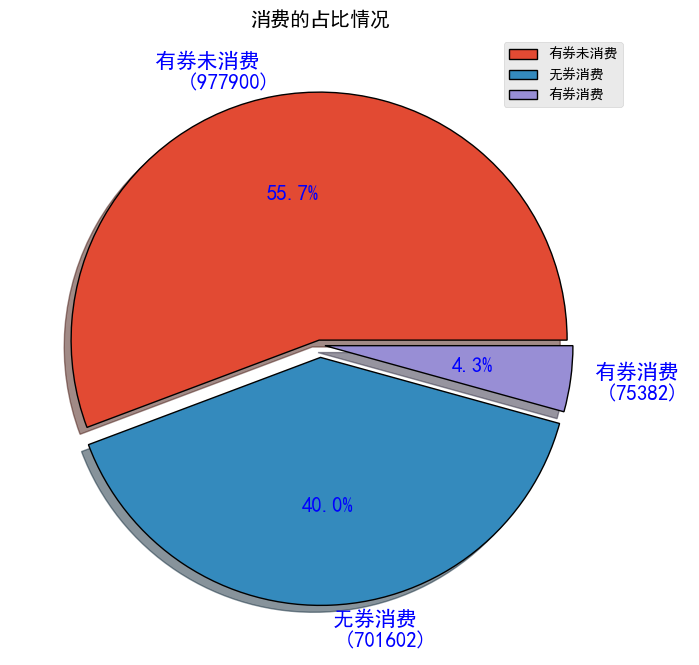

In [94]:
# 绘制优惠券使用情况饼图
dic = {
    '有优惠券未消费的人数':len(coupon_no_consume),
    '无券消费的人数':len(no_coupon_consume),
    '有优惠券并进行消费的人数':len(coupon_consume)
}
consume_status = pd.Series(dic)

fig,ax = plt.subplots(1,1,figsize=(8,10))
consume_status.plot.pie(ax=ax,
             autopct='%1.1f%%',  
             shadow=True,       # 阴影
             explode=[0.02,0.05,0.02],  # 数据间隔
             textprops={'fontsize':15,'color':'blue'},   # 文本属性
             wedgeprops={'linewidth':1,'edgecolor':'black'},  # 边界属性（宽度1，颜色黑）
             labels=['有券未消费 \n ({})'.format(len(coupon_no_consume)),
                               '无券消费 \n ({})'.format(len(no_coupon_consume)),
                               '有券消费 \n ({})'.format(len(coupon_consume))]
            )
ax.set_title('消费的占比情况')
plt.legend(labels = ['有券未消费','无券消费','有券消费'])

#### 3.1在有券消费人群中，分析距离和优惠折扣对用券消费人群的影响

有持券消费的商家数:4076
持券消费的用户在商家附近消费的人数:1431
所有商家折扣的平均值:0.88


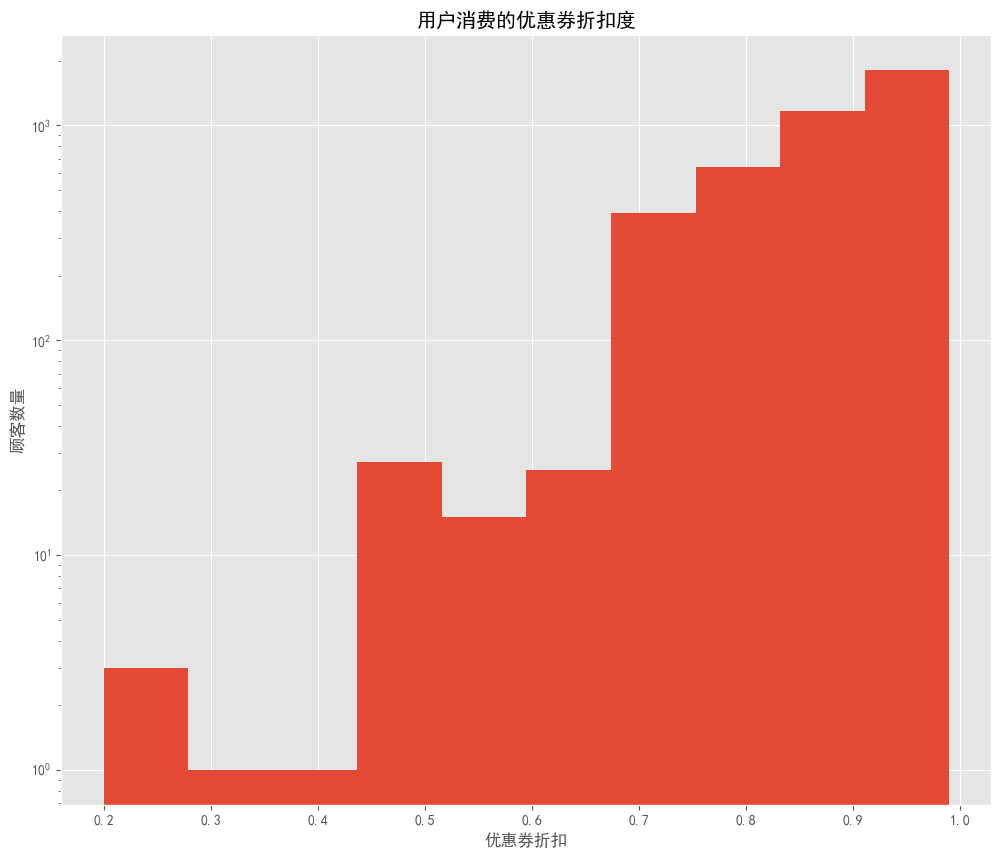

In [111]:
# 各商家对应的顾客消费距离
consume_distance = coupon_consume.groupby('Merchant_id')['Distance'].mean().sort_values(ascending = False)
print(f'有持券消费的商家数:{format(len(consume_distance))}')
print('持券消费的用户在商家附近消费的人数:{}'.format(len(consume_distance[consume_distance==0])))

# 各商家对应的顾客到店消费平均折扣力度
consume_discount =  coupon_consume.groupby('Merchant_id')['Discount_rate'].mean().sort_values(ascending = False)
plt.figure(figsize=(12,10))
consume_discount.plot.hist()
plt.xlabel('优惠券折扣')
plt.ylabel('顾客数量')
plt.yscale('log')
plt.title('用户消费的优惠券折扣度')
print('所有商家折扣的平均值:{}'.format(round(consume_discount.mean(),2)))

#### 3.2持券到店消费人数最多的商家

In [117]:
# 对商家进行分组，取出用户id，对用户id进行去重统计数量
popular_merchant = coupon_consume.groupby('Merchant_id')['User_id'].nunique()

# 找出持券消费人数>500的商家id
popular_merchant500 = popular_merchant[popular_merchant>500]
print('持券消费人数大于500人的商家量是:{}'.format(len(popular_merchant500)))
print(popular_merchant500)

# 共16家店铺持券消费人数在500人以上
# 持券消费人数最多商家是5341，持券消费人数在2800（可能存在一个用户持券多次消费）

持券消费人数大于500人的商家量是:16
Merchant_id
450     1094
760     2627
1379     587
1433     559
1469     584
1520     870
2099    1401
2934    1310
3381    2248
3532     968
3621     851
4142     832
5341    2800
6485    2029
6901     855
7555     925
Name: User_id, dtype: int64


#### 3.3持券消费人数在500人以上的商家，链接顾客到店平均距离和平均折扣力度

In [122]:
popular_merchant500.name='cumsumer_count'  
merchant_pop_dis = pd.merge(left=popular_merchant500,right=consume_distance,on='Merchant_id')
merchant_pop_dis_rate = pd.merge(left=merchant_pop_dis,right=consume_discount,on='Merchant_id')
merchant_pop_dis_rate

,cumsumer_count,Distance,Discount_rate
Merchant_id,,,
450,1094,0.892164,0.819274
760,2627,0.349866,0.799873
1379,587,0.706250,0.830096
1433,559,1.054962,0.825959
1469,584,2.092800,0.721870
1520,870,NaN,0.925632
2099,1401,0.968072,0.900000
2934,1310,1.114833,0.830000
3381,2248,1.652429,0.744150


#### 3.4计算到店消费人数与平均距离和折扣力度的相关系数

In [5]:
# corr(correlation:相关系数)，用来计算df数据中列与列的相关性（皮尔逊相关系数）
# 取值范围[-1,1];   1：完全正相关，-1：完全负相关
# 正相关：随着变量的增大，而增大，反之同理
# 负相关：随着变量的增大，而减小，反之同理

merchant_pop_dis_rate.corr()
# 持券消费人数与距离和折扣率都呈负相关，

<Axes: >

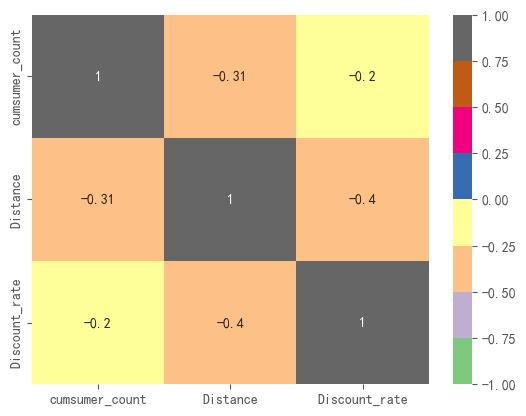

In [123]:
# 用热力图展示相关系数
sns.heatmap(data=merchant_pop_dis_rate.corr(),annot=True,cmap='Accent',vmax=1,vmin=-1)

# 由图可知：
# 1.到店消费人数的多少与顾客到店的距离呈负相关，相关系数0.31，为低度相关
# 2.到店消费人数的多少与优惠打折力度呈现负相关，相关系数0.2，为极弱相关

#### 3.5优惠券的使用和发放情况

In [126]:
print(offline['Date'].notnull().sum())   # 77.7万消费数据
print(offline['Date_received'].notnull().sum())   # 已经发送出105万优惠券

np.int64(1754884)

In [135]:
# 取出存在消费日期的记录，进行升序，再去重
date_sort = offline[offline['Date'].notnull()]['Date'].sort_values().unique()
date_sort[:5]

<DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-03 00:00:00',
 '2016-01-04 00:00:00', '2016-01-05 00:00:00']
Length: 5, dtype: datetime64[ns]

In [136]:
# 取出存在领券日期的记录，进行升序，再去重
date_receive_sort = offline[offline['Date_received'].notnull()]['Date_received'].sort_values().unique()
date_receive_sort[:5]

<DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-03 00:00:00',
 '2016-01-04 00:00:00', '2016-01-05 00:00:00']
Length: 5, dtype: datetime64[ns]

In [144]:
# 某一天发的优惠券的使用量（即持某天的券消费人数）
coupon_everyday = coupon_consume[['Date_received','User_id']]
coupon_everyday = coupon_everyday.groupby('Date_received')['User_id'].count()
coupon_everyday

Date_received
2016-01-01     74
2016-01-02     67
2016-01-03     74
2016-01-04     98
2016-01-05    107
             ... 
2016-06-11    351
2016-06-12    330
2016-06-13    439
2016-06-14    394
2016-06-15    355
Name: User_id, Length: 167, dtype: int64

In [148]:
# 每天发放的优惠券数量(取出所有领券日期！=null的数据，在进行按天分组，计数就可以)
# 每天优惠券的发放量（即持券人数）
coupon_sendout_everyday = offline[offline['Date_received'].notnull()]
coupon_sendout_everyday = coupon_sendout_everyday.groupby('Date_received')['User_id'].count()
coupon_sendout_everyday

Date_received
2016-01-01     554
2016-01-02     542
2016-01-03     536
2016-01-04     577
2016-01-05     691
              ... 
2016-06-11    5211
2016-06-12    4005
2016-06-13    7861
2016-06-14    4755
2016-06-15    3475
Name: User_id, Length: 167, dtype: int64

In [11]:
#绘制每天发券量和每天用券量
plt.figure(figsize=(18,6))
plt.bar(x=date_receive_sort,height=coupon_sendout_everyday['count'],label='每天发券量',color = 'blue')
plt.bar(x=date_receive_sort,height=coupon_everyday['count'],label='每天用券量')
plt.yscale('log')  #对y轴进行对数缩放
plt.legend()

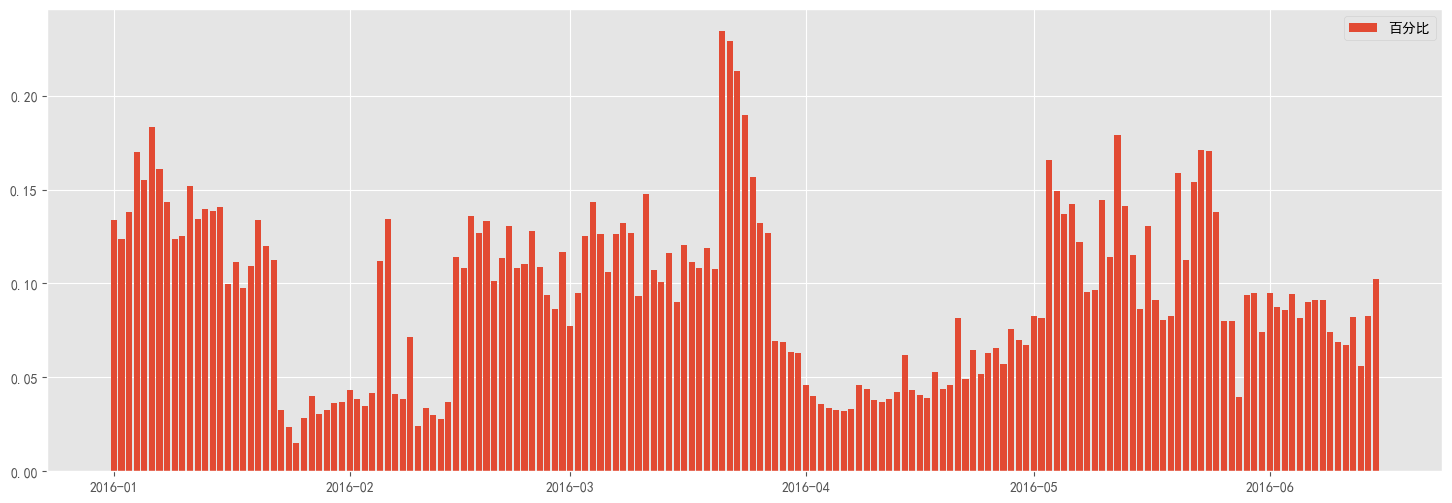

In [146]:
# 计算每天的优惠券与发券量占比
plt.figure(figsize=(18,6))
plt.bar(x=date_receive_sort,
        height=(coupon_everyday/coupon_sendout_everyday),
        label='百分比')
plt.legend()